# 畳み込みニューラルネットワーク (Convolutional Neural Network:CNN)

CNN は特定のタスクにとって、最も有益な特徴量を生データから抽出することができる。その構成は複数の畳み込み層（convolutional layer）、サブサンプリング層（subsampling layer または pooling layer）、全結合層となっている。

畳み込み層では低レベルの特徴量を抽出する。サブサンプリング層には学習可能なパラメータはない。全結合層では抽出された特徴量でもって連続地の目的変数やクラスラベルを予測する。

畳み込み層では入力データを畳み込んでいる。実装上重要なことは入力データのサイズ、カーネルサイズ、パディング数、ストライド数であり、これらは出力のサイズを決める。通常これらは出力サイズが入力サイズと同じになるように設定されることが多い。

サンプリング層ではプーリング演算される。2種類あり、最大値プーリングと平均値プーリングである。通常、オーバーラップなしで行われる。

## CNN の実装
従来の多層ニューラルネットワークにおける演算は $z = Wx + b$ のような形をしていた。CNN ではこれが畳み込み演算 $Z = W \ast X + b$ という形に置き換えられる。

### 入力データ
画像を扱う場合は $X_{N1 \times N2 \times C_{in}}$ のような3階のテンソル表現が入力になる。$C_{in}$ は入力チャネルの個数を表す（カラーの場合は RGB の3）。

### ネットワークの正則化
ネットワークのパラメータが多くなるとキャパシティが大きくなり、表現できる関数の複雑さが増す。一方で過学習の傾向に陥りやすくもなる。ある程度の正則化を施す必要がある。例えば `keras` の `regularizer` によって層に L2 正則化を施すことができる。またドロップアウトによる正則化を施すこともできる。

### 分類の損失関数
さまざまな活性化関数があり、隠れ層の活性化関数で用いられるものもあれば、出力する最後の層に用いられるものもある。
- ReLU などは非線形性を追加するために中間層で用いられる活性化関数である
- シグモイド（二値分類）やソフトマックス（多クラス分類）などはクラス所属確率を生成するために最後の層に追加される

## 多層CNNアーキテクチャ
入力テンソル次元が 28 * 28 * 1 に対するCNNを構築する。カーネルサイズを 5 * 5 にし、2 * 2 のプーリングを行う。

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

In [3]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
# 最初にシャッフルされなくなるため、あとで訓練データをさらに分割したいときに便利である。
# True にした場合はミニバッチを取得するたびにデータセットがシャッフルされる。

mnist_train_orig = datasets['train']
mnist_test_orig = datasets['test']

2024-10-19 20:49:21.802770: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-19 20:49:21.904337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 20:49:21.939130: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-19 20:49:21.948982: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-19 20:49:22.021873: I tensorflow/core/platform/cpu_feature_guar

/home/hoyo/work/training/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 100%|██████████| 5/5 [00:01<00:00,  3.11 file/s]
I0000 00:00:1729338567.405291  173183 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Dataset mnist downloaded and prepared to /home/hoyo/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


2024-10-19 20:49:27.529415: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
# 訓練データと検証データの分割
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20

mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                  tf.cast(item['label'], tf.int32))
)
mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                  tf.cast(item['label'], tf.int32))
)

tf.random.set_seed(1)
mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE,
                                  reshuffle_each_iteration=False)
mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

### CNN の実装
`Conv2D`層では、出力フィルタの個数（出力特徴量マップの個数に等しい、出力ノードのイメージ）、カーネルサイズ、ストライドとパディングを設定することができる。ストライドのデフォルトはx,yともに1である。パディングは same mode か valid mode になる。

画像を読み込むとき、通常はテンソル配列の最後の次元がチャネルのデフォルトの次元となる（NHWC方式と呼ばれる）。N はバッチ内の画像の個数、H と W は高さと幅、C はチャネルを表す。PyTorch などは NCHW方式を使っていたりする。このあたりの調整は `data_format`     パラメータによって指定することができる: NHWC = `channels_last`, NCHW = `channels_fisrt`。

In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1),
                                 padding='same', data_format='channels_last',
                                 name='conv_1', activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_1'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1),
                                 padding='same', name='conv_2', activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))


In [7]:
# 特徴量マップのサイズの計算
model.compute_output_shape(input_shape=(16, 28, 28, 1))

(16, 7, 7, 64)

畳み込み層とプーリング層に基づいて分類器を実装するための全結合層を追加する。この層に対する入力の階数は2でなければならない（バッチサイズX入力ユニット数（ようは特徴量））。そのため、前の層の出力を平坦化する必要がある。

In [8]:
model.add(tf.keras.layers.Flatten())
model.compute_output_shape(input_shape=(16, 28, 28, 1))

(16, 3136)

In [9]:
model.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=10, name='fc_2', activation='softmax'))

one-hot endcoding ではなく整数値の疎なラベルに基づく多クラス分類では、`SparseCategoricalCrossentropy`関数を使う。

In [13]:
tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 1))
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [14]:
history = model.fit(mnist_train,
                    epochs=NUM_EPOCHS,
                    validation_data=mnist_valid,
                    shuffle=True)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8991 - loss: 0.3231 - val_accuracy: 0.9833 - val_loss: 0.0563
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9858 - loss: 0.0472 - val_accuracy: 0.9871 - val_loss: 0.0441
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9897 - loss: 0.0320 - val_accuracy: 0.9890 - val_loss: 0.0355
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9908 - loss: 0.0279 - val_accuracy: 0.9901 - val_loss: 0.0323
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9941 - loss: 0.0188 - val_accuracy: 0.9902 - val_loss: 0.0423
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9944 - loss: 0.0183 - val_accuracy: 0.9898 - val_loss: 0.0413
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9959 - loss: 0.0130 - val_accuracy: 0.9898 - val_loss: 0.0452
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9959 - loss: 0.0128 - 

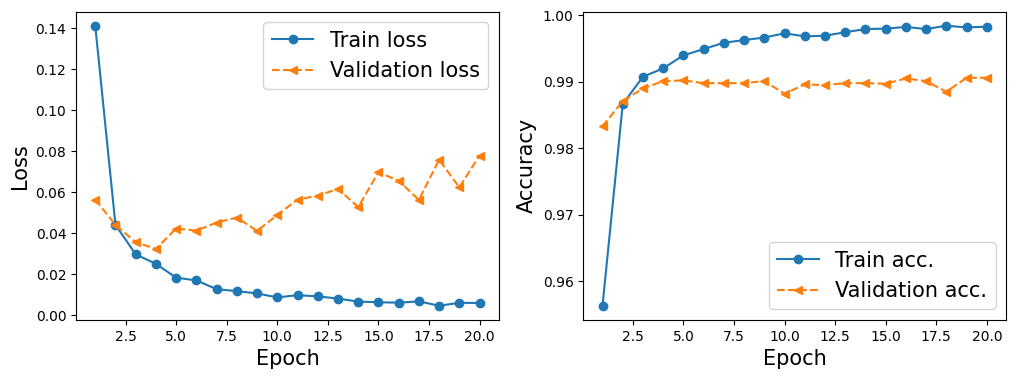

In [16]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/15_12.png', dpi=300)
plt.show()

In [17]:
test_results = model.evaluate(mnist_test.batch(20))
print(f'Test Acc.: {test_results[1]*100:.2f}')

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9910 - loss: 0.0636
Test Acc.: 99.05


予測値をクラス所属確率として取得し、tf.argmax関数で最大の要素を特定し、ラベルに変換する

TensorShape([12, 10])
tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


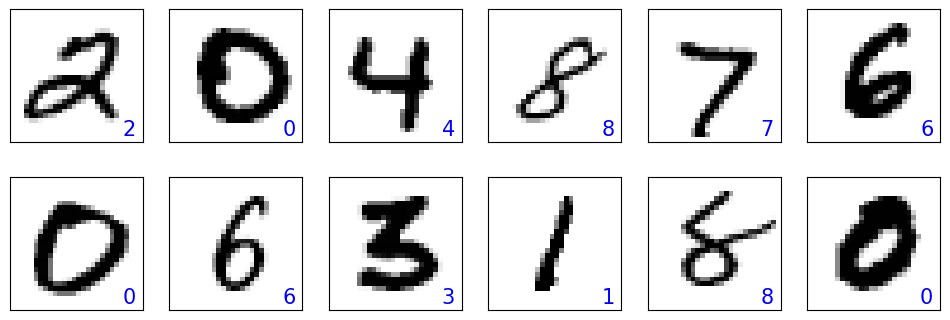

In [18]:
batch_test = next(iter(mnist_test.batch(12)))

preds = model(batch_test[0])

tf.print(preds.shape)
preds = tf.argmax(preds, axis=1)
print(preds)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
#plt.savefig('figures/15_13.png', dpi=300)
plt.show()